In [1]:
#
# NCFApp
# New Customers Forecast Application
# Programma creato per il forecast dei clienti
# 

import numpy             as np   # libreria per la gestione dei numeri
import pandas            as pd   # libreria per la gestione del file csv
import seaborn           as sb   # libreria per la costruzione di grafici
import matplotlib.pyplot as plt  # libreria ausiliaria per la costruzione di grafici
import Tkinter           as tk   # libreria per l'interfaccia grafica


# Carica il dataframe dei dati dal file csv

df_sstor = pd.read_csv('NCFAdati.csv',sep=';')


In [3]:
df_totbdt = pd.DataFrame()
df_totbdt['MESE'] = df_sstor['MESE']
df_totbdt['FL_BDT'] = df_sstor['FL_IMP']+df_sstor['FL_PER']+df_sstor['FL_AZR']+df_sstor['FL_RET']
df_totbdt['CP_BDT'] = df_sstor['CP_IMP']+df_sstor['CP_PER']+df_sstor['CP_AZR']+df_sstor['CP_RET']
df_totbdt['ST_BDT'] = df_sstor['ST_IMP']+df_sstor['ST_PER']+df_sstor['ST_AZR']+df_sstor['ST_RET']

In [4]:
df_totbdt.head()


,MESE,FL_BDT,CP_BDT,ST_BDT
0,2011/01,55585.0,44247.0,10972151.0
1,2011/02,51884.0,53427.0,10970006.0
2,2011/03,60323.0,56578.0,10973294.0
3,2011/04,48007.0,43572.0,10977287.0
4,2011/05,56494.0,53478.0,10991212.0


In [6]:
def Lastcons():
    df_mesi = df_sstor['MESE']
    return max(df_mesi)

print Lastcons()

2017/06


In [24]:
# Funzione che prepara un grafico e lo salva in una figura
def SimplePlot(SeriePandas=None,LabelofSerie=None):
    plt.plot(SeriePandas,label=LabelofSerie)
    plt.legend()
    plt.show()
    return plt.figure()

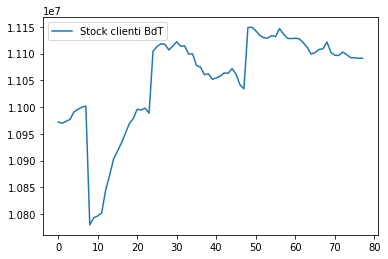

In [25]:
SimplePlot(df_totbdt['ST_BDT'],'Stock clienti BdT')

In [8]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, **kwargs)
    Plot lines and/or markers to the
    :class:`~matplotlib.axes.Axes`.  *args* is a variable length
    argument, allowing for multiple *x*, *y* pairs with an
    optional format string.  For example, each of the following is
    legal::
    
        plot(x, y)        # plot x and y using default line style and color
        plot(x, y, 'bo')  # plot x and y using blue circle markers
        plot(y)           # plot y using x as index array 0..N-1
        plot(y, 'r+')     # ditto, but with red plusses
    
    If *x* and/or *y* is 2-dimensional, then the corresponding columns
    will be plotted.
    
    If used with labeled data, make sure that the color spec is not
    included as an element in data, as otherwise the last case
    ``plot("v","r", data={"v":..., "r":...)``
    can be interpreted as the first case which would do ``plot(v, r)``
    using the default line style and color.
    
    If not used wi

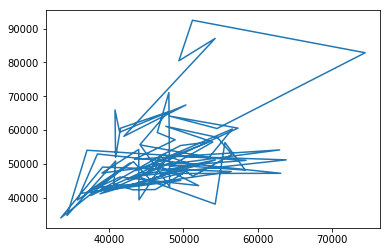

In [17]:
plt.plot(df_totbdt['CP_BDT'],df_totbdt['FL_BDT'])
plt.show()
#plt.gcf().canvas.draw()
fig = plt.figure()

In [19]:
fig
print fig

Figure(432x288)


In [20]:
# Frame principale

class Application(tk.Frame):
    def __init__(self, master=None):
        tk.Frame.__init__(self, master)
        self.grid()
        self.createWidgets()

    def createWidgets(self):
        self.quitButton = tk.Button(self, text='Quit', command=self.quit)
        self.quitButton.grid()
        
    def quit(self):
        self.destroy()
        return 

app = Application()
app.master.title('New Customers Forecast Application - rel. 1.0 - (C) Gianni Zattoni')
app.mainloop()

In [16]:
plt.plot(['a','2','3'], [1,2,3], 'go-', label='line 1', linewidth=2)
plt.plot(['a','2','3'], [1,4,9], 'rs',  label='line 2')
plt.axis([0, 4, 0, 10])
plt.legend()
plt.show()

ValueError: could not convert string to float: a

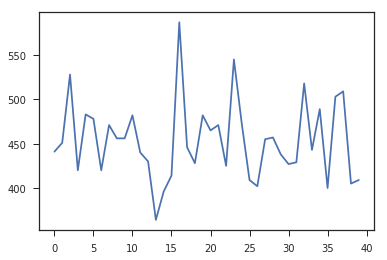

<class 'matplotlib.figure.Figure'>


IndexError: tuple index out of range

In [31]:

# prova di visualizzazione del grafico

#sb.set(style="ticks")
#pos = rs.randint(-1, 2, (20, 5)).cumsum(axis=1)
#pos -= pos[:, 0, np.newaxis]
#step = np.tile(range(5), 20)
#walk = np.repeat(range(20), 5)

# Initialize a grid of plots with an Axes for each walk
#grid = sb.FacetGrid(d_somma, col="walk", hue="walk", col_wrap=5, size=1.5)

# Draw a horizontal line to show the starting point
#grid.map(plt.axhline, y=0, ls=":", c=".5")

# Draw a line plot to show the trajectory of each random walk
#grid.map(plt.plot, "step", "position", marker="o", ms=4)

# Adjust the tick positions and labels
#grid.set(xticks=np.arange(5), yticks=[-3, 3],
#         xlim=(-.5, 4.5), ylim=(-3.5, 3.5))

# Adjust the arrangement of the plots
#grid.fig.tight_layout(w_pad=1)



print type(fig)
graphic = tk.Canvas(app)
q = graphic.create_image(x=1, y=1, image=fig) #canvas.get_tk_widget().grid(row=1,column=24)
canvas.draw()


# create the canvas, size in pixels
#canvas = Canvas(width=300, height=200, bg='black')

# pack the canvas into a frame/form
#canvas.pack(expand=YES, fill=BOTH)

# load the .gif image file
#gif1 = PhotoImage(file='small_globe.gif')

# put gif image on canvas
# pic's upper left corner (NW) on the canvas is at x=50 y=10
#canvas.create_image(50, 10, image=gif1, anchor=N